In [1]:
# HIDDEN
using CSV
using DataFrames
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Linear Regression Case Study

In this section, we perform an end-to-end case study of applying the linear regression model to a dataset. The dataset we will be working with has various attributes, such as length and girth, of donkeys.

Our task is to predict a donkey's weight using linear regression.

## Preliminary Data Overview

We will begin by reading in the dataset and taking a quick peek at its contents.

In [2]:
donkeys = CSV.read("donkeys.csv"; missingstring="NA")

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
,Float64,String,String,Int64,Int64,Int64,Int64,Int64⍰
1,3.0,<2,stallion,78,90,90,77,missing
2,2.5,<2,stallion,91,97,94,100,missing
3,1.5,<2,stallion,74,93,95,74,missing
4,3.0,<2,female,87,109,96,116,missing
5,2.5,<2,female,79,98,91,91,missing
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


It's always a good idea to look at _how much_ data we have by looking at the dimensions of the dataset. If we have a large number of observations, printing out the entire dataframe may crash our notebook.

In [3]:
size(donkeys)

(544, 8)

The dataset is relatively small, with only 544 rows of observations and 8 columns. Let's look at what columns are available to us.

In [4]:
print(names(donkeys))

Symbol[:BCS, :Age, :Sex, :Length, :Girth, :Height, :Weight, :WeightAlt]

A good understanding of our data can guide our analysis, so we should understand what each of these columns represent. A few of these columns are self-explanatory, but others require a little more explanation:

- `BCS`: Body Condition Score (a physical health rating)
- `Girth`: the measurement around the middle of the donkey
- `WeightAlt`: the second weighing (31 donkeys in our data were weighed twice in order to check the accuracy of the scale)

It is also a good idea to determine which variables are quantitative and which are categorical.

Quantitative: `Length`, `Girth`, `Height`, `Weight`, `WeightAlt`

Categorical: `BCS`, `Age`, `Sex`


## Data Cleaning

In this section, we will check the data for any abnormalities that we have to deal with.

By examining `WeightAlt` more closely, we can make sure that the scale is accurate by taking the difference between the two different weighings and plotting them.

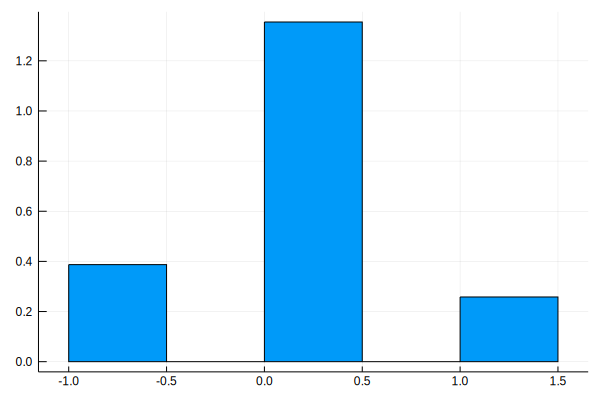

In [5]:
difference = donkeys.WeightAlt - donkeys.Weight
histogram(collect(skipmissing(difference)), norm=:pdf, legend=false)

The measurements are all within 1 kg of each other, which seems reasonable.

Next, we can look for unusual values that might indicate errors or other problems. We can use the quantile function on our quantitative columns in order to detect anomalous values.

In [6]:
quantile_df = DataFrame()
quantitative_cols = [:BCS, :Length, :Girth, :Height, :Weight, :WeightAlt]
for col in quantitative_cols
    values = quantile(skipmissing(donkeys[:, col]), [0.005, 0.995])
    quantile_df[!, col] = values
end

quantile_df

,BCS,Length,Girth,Height,Weight,WeightAlt
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.5,71.145,90.0,89.0,71.715,98.75
2,4.0,111.0,131.285,112.0,214.0,192.8


For each of these numerical columns, we can look at which rows fall outside of these quantiles and what values they take on. Consider that we want our model to apply to only healthy and mature donkeys.

First, let's look at the `BCS` column.

In [7]:
print(donkeys[(donkeys.BCS .< 1.5) .| (donkeys.BCS .> 4), :BCS])

[4.5, 1.0]

Also looking at the barplot of `BCS`:

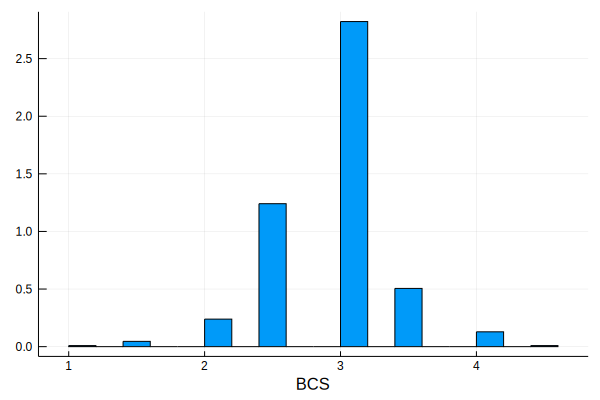

In [8]:
@df donkeys histogram(:BCS, xlabel="BCS", norm=:pdf, legend=false)

Considering that `BCS` is an indication of the health of a donkey, a `BCS` of 1 represents an extremely emaciated donkey and a `BCS` of 4.5 an overweight donkey. Also looking at the barplot, there only appear to be two donkeys with such outlying `BCS` values. Thus, we remove these two donkeys.

---

Now, let's look at `Length`, `Girth`, and `Height`.

In [9]:
print(donkeys[(donkeys.Length .< 71.145) .| (donkeys.Length .> 111), :Length])

[46, 68, 69, 112]

In [10]:
print(donkeys[(donkeys.Girth .< 90) .| (donkeys.Girth .> 131.285), :Girth])

[66, 132, 134, 134]

In [11]:
print(donkeys[(donkeys.Height .< 89) .| (donkeys.BCS .> 112), :Height])

[71, 86]

For these three columns, the donkey in row 9 seems to have a much smaller value than the cut-off while the other anomalous donkeys are close to the cut-off and likely do not need to be removed.

In [12]:
donkeys[9, :]

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
,Float64,String,String,Int64,Int64,Int64,Int64,Int64⍰
9,3.0,<2,stallion,46,66,71,27,missing


---
Finally, let's take a look at `Weight`:

In [13]:
print(donkeys[(donkeys.Weight .< 71.715) .| (donkeys.Weight .> 214), :Weight])

[27, 65, 71, 227, 230]

The first 2 and last 2 donkeys in the list are far off from the cut-off and most likely should be removed. The middle donkey can be included.

---

Since `WeightAlt` closely corresponds to `Weight`, we skip checking this column for anomalies. Summarizing what we have learned, here is how we want to filter our donkeys:

- Keep donkeys with `BCS` in the range 1.5 and 4
- Keep donkeys with `Weight` between 71 and 214  

In [14]:
donkeys_c = donkeys[(donkeys.BCS .>= 1.5) .& (donkeys.BCS .<=4) .&
    (donkeys.Weight) .>=71 .& (donkeys.Weight .<= 214), :]

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
,Float64,String,String,Int64,Int64,Int64,Int64,Int64⍰
1,3.0,<2,stallion,78,90,90,77,missing
2,2.5,<2,female,79,98,91,91,missing
3,1.5,<2,female,86,102,98,105,missing
4,3.0,<2,stallion,46,66,71,27,missing
5,3.0,<2,stallion,92,110,99,141,missing
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


## Train-Test Split

Before we proceed with our data analysis, we divide our data into an 80/20 split, using 80% of our data to train our model and setting aside the other 20% for evaluation of the model.

We will be using the Julia package for Machine Learning `MLJ`. The function `unpack` will create our `X` and `y` arrays with the specified target dimension. The function `partition` will split the indexes of our target array `y`:

In [15]:
using MLJ

y, X = unpack(donkeys_c, ==(:Weight), colname -> true;
    :BCS=>Continuous, :Length=>Continuous, :Girth=>Continuous, :Height=>Continuous, :Weight=>Continuous,
    :Age=>Multiclass, :Sex=>Multiclass, :WeightAlt=>Union{Missing, Multiclass})
train, test = partition(eachindex(y), 0.8, shuffle=true)
size(train), size(test)

((202,), (51,))

Let's also create a function that evaluates our predictions on the test set. Let's use mean squared error. 

In [16]:
mse_test_set(yhat, y) = sum((yhat .- y) .^ 2);

## Exploratory Data Analysis and Visualization

As usual, we will explore our data before attempting to fit a model to it.

First, we will examine the categorical variables with boxplots.

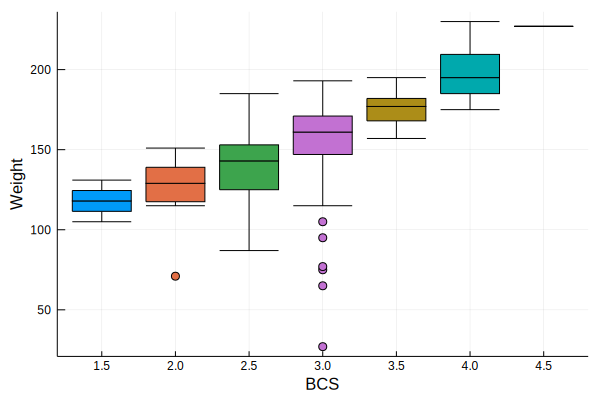

In [17]:
# HIDDEN
boxplot(X[train, :BCS], y[train], bar_width=0.4, legend=false, group=X[train, :BCS])
xlabel!("BCS")
ylabel!("Weight")

It seems like median weight increases with BCS, but not linearly.

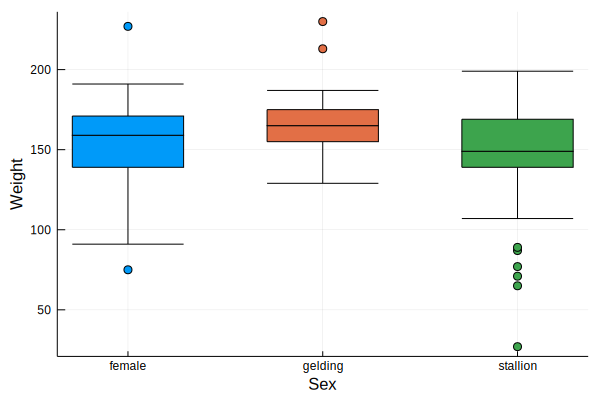

In [18]:
# HIDDEN
boxplot(X[train, :Sex], y[train], legend=false, group=X[train, :Sex])
xlabel!("Sex")
ylabel!("Weight")

It seems like the sex of the donkey doesn't appear to cause much of a difference in weight.

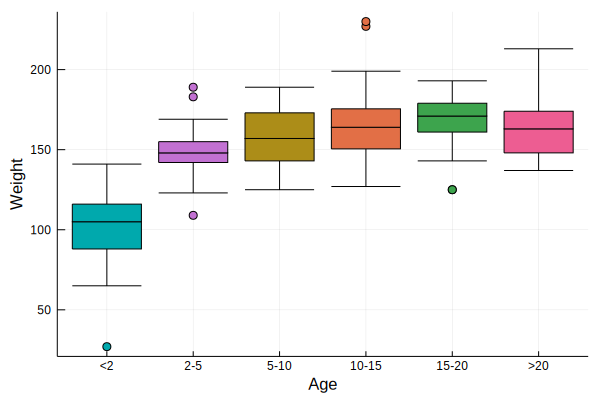

In [19]:
# HIDDEN
using CategoricalArrays

age_c = CategoricalArray(X[train, :Age])
levels!(age_c, ["<2", "2-5", "5-10", "10-15", "15-20", ">20"])

age_df = DataFrame(Age = age_c, Weight = y[train])
sort!(age_df, :Age)

# Scatter plot first as it takes in consideration the categorical order we set for the x axis
@df age_df scatter(:Age, :Weight, legend=false, markeralpha=0)
@df age_df boxplot!(:Age, :Weight, legend=false, xlabel="Age", ylabel="Weight", group=:Age)

For donkeys over 5, the weight distribution is not too different.

Now, let's look at the quantitative variables. We can plot each of them against the target variable.

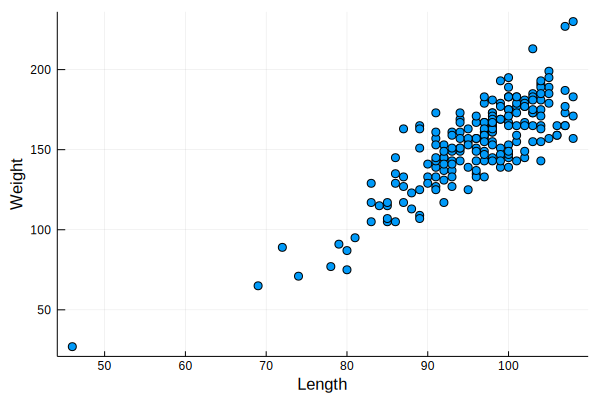

In [20]:
# HIDDEN
scatter(X[train, :Length], y[train], legend=false, xlabel="Length", ylabel="Weight")

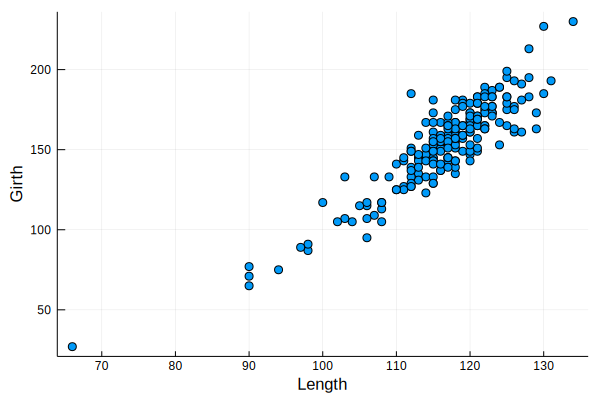

In [21]:
# HIDDEN
scatter(X[train, :Girth], y[train], legend=false, xlabel="Length", ylabel="Girth")

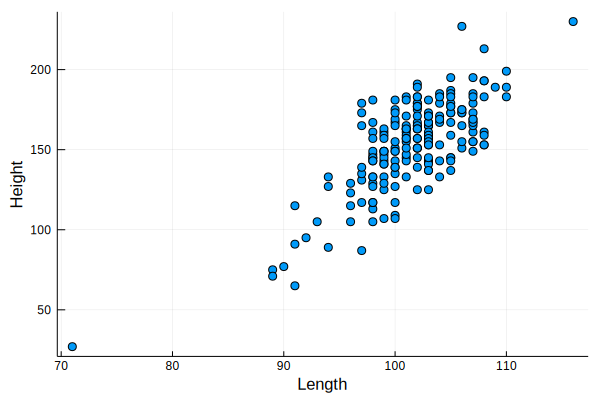

In [22]:
# HIDDEN
scatter(X[train, :Height], y[train], legend=false, xlabel="Length", ylabel="Height")

All three of our quantitative features have a linear relationship with our target variable of `Weight`, so we will not have to perform any transformations on our input data.

It is also a good idea to see if our features are linear with each other. We plot two below: 

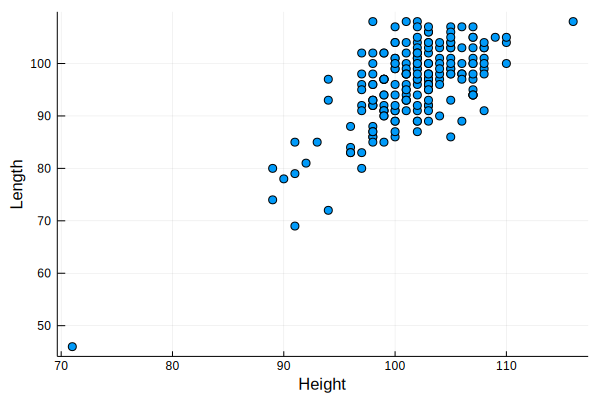

In [23]:
# HIDDEN
scatter(X[train, :Height], X[train, :Length], legend=false, xlabel="Height", ylabel="Length")

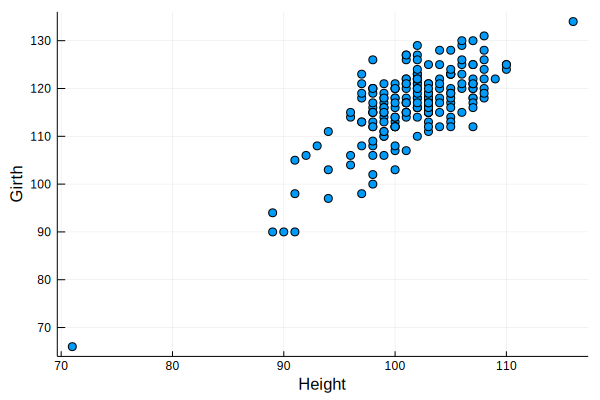

In [24]:
# HIDDEN
scatter(X[train, :Height], X[train, :Girth], legend=false, xlabel="Height", ylabel="Girth")

From these plots, we can see that our predictor variables also have strong linear relationships with each other. This makes our model harder to interpret, so we should keep this in mind after we create our model.

## Simpler Linear Models

Rather than using all of our data at once, let's try to fit linear models to one or two variables first. 

Below are three simple linear regression models using just one quantitative variable. Which model appears to be the best?

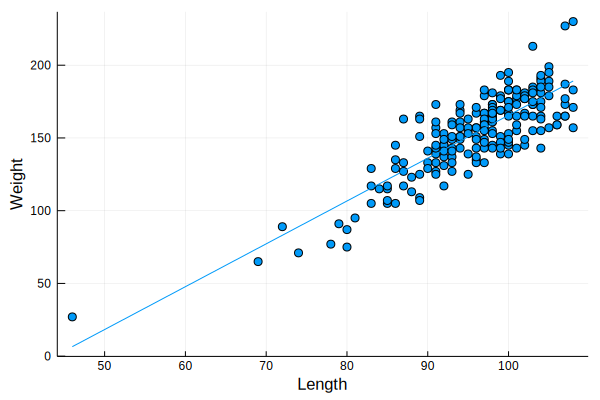

In [25]:
# HIDDEN
scatter(X[train, :Length], y[train], legend=false, xlabel="Length", ylabel="Weight", regression=true)

In [26]:
# HIDDEN
lr_model = @load LinearRegressor pkg=ScikitLearn

X_height = DataFrame(Height=X.Height)
lr = machine(lr_model, X_height, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test)
mse_test_set(yhat, y[test])

┌ Info: Training Machine{LinearRegressor} @ 1…16.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


12934.460287478458

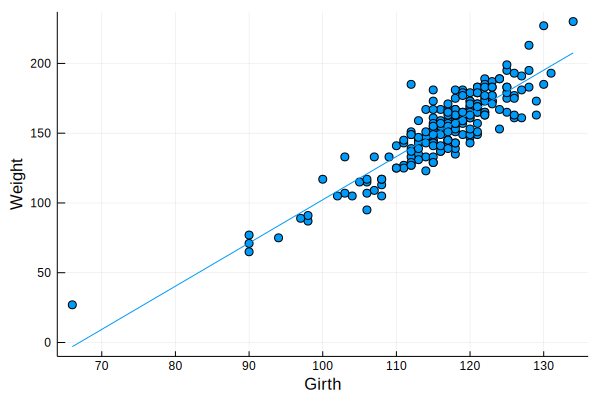

In [27]:
# HIDDEN
scatter(X[train, :Girth], y[train], legend=false, xlabel="Girth", ylabel="Weight", regression=true)

In [28]:
# HIDDEN
X_girth = DataFrame(Girth=X.Girth)
lr = machine(lr_model, X_girth, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test)
mse_test_set(yhat, y[test])

┌ Info: Training Machine{LinearRegressor} @ 6…57.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


5916.478590463199

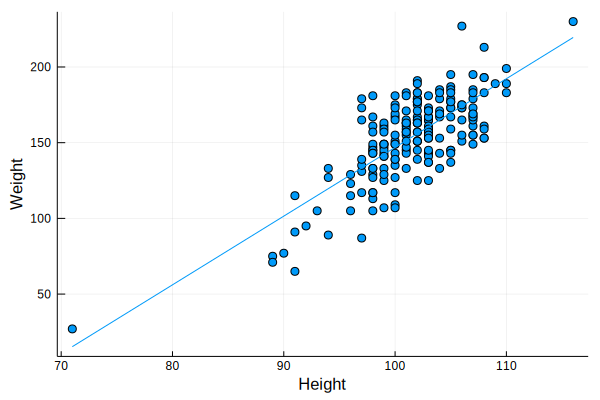

In [29]:
# HIDDEN
scatter(X[train, :Height], y[train], legend=false, xlabel="Height", ylabel="Weight", regression=true)

In [30]:
# HIDDEN
X_height = DataFrame(Height=X.Height)
lr = machine(lr_model, X_height, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test)
mse_test_set(yhat, y[test])

┌ Info: Training Machine{LinearRegressor} @ 1…89.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


12934.460287478458

Looking at the scatter plots and the mean squared errors, it seems like `Girth` is the best sole predictor of `Weight` as it has the strongest linear relationship with `Weight` and the smallest mean squared error.

Can we do better with two variables? Let's try fitting a linear model using both `Girth` and `Length`. Although it is not as easy to visualize this model, we can still look at the MSE of this model.

In [31]:
# HIDDEN
X_girth_length = DataFrame(Girth=X.Girth, Length=X.Length)
lr = machine(lr_model, X_girth_length, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test)
mse_test_set(yhat, y[test])

┌ Info: Training Machine{LinearRegressor} @ 2…38.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


4237.8196130566

Looks like our MSE went down from around 6000 with just `Girth` alone to 5000 with `Girth` and `Length`. Using including the second variable improved our model.

We can also use categorical variables in our model. Let's now look at a linear model using the categorical variable of `Age`. This is the plot of `Age` versus `Weight`:

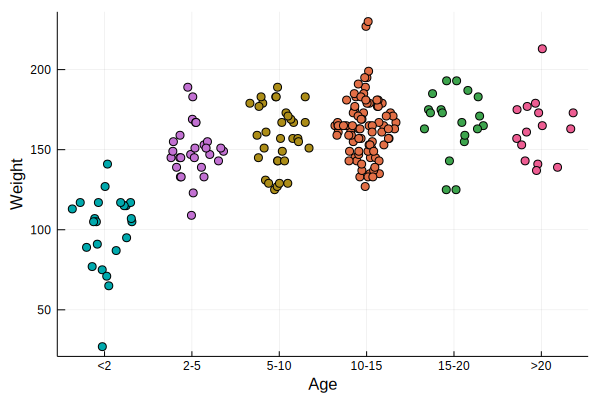

In [32]:
# HIDDEN
@df age_df scatter(:Age, :Weight, legend=false, markeralpha=0)
@df age_df dotplot!(:Age, :Weight, legend=false, xlabel="Age", ylabel="Weight", group=:Age)

Seeing how `Age` is a categorical variable, we need to introduce dummy variables in order to produce a linear regression model.

In [110]:
# HIDDEN
X_age = DataFrame(Age=X.Age)
for c in unique(X_age.Age)
    X_age[!, Symbol(c)] = ifelse.(X_age.Age .== c, 1, 0)
end

X_age_encoded = coerce(X_age, Symbol("<2")=>Continuous,
    Symbol("2-5")=>Continuous,
    Symbol("5-10")=>Continuous,
    Symbol("10-15")=>Continuous,
    Symbol("15-20")=>Continuous,
    Symbol(">20")=>Continuous
)

X_age_encoded_df = select(X_age_encoded, Not([:Age]))
lr = machine(lr_model, X_age_encoded_df, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test)
mse_test_set(yhat, y[test])

┌ Info: Training Machine{LinearRegressor} @ 5…50.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


17077.363860786718

A MSE of around 20000 is worse than what we could get using any single one of the quantitative variables, but this variable could still prove to be useful in our linear model.

Let's try to interpret this linear model. Note that every donkey that falls into an age category, say 2-5 years of age, will receive the same prediction because they share the input values: a 1 in the column corresponding to 2-5 years of age, and 0 in all other columns. Thus, we can interpret categorical variables as simply changing the constant in the model because the categorical variable separates the donkeys into groups and gives one prediction for all donkeys within that group.

Our next step is to create a final model using both our categorical variables and multiple quantitative variables.

## Transforming Variables

Recall from our boxplots that `Sex` was not a useful variable, so we will drop it. We will also remove the `WeightAlt` column because we only have its value for 31 donkeys. Finally, we will write a function to transform categorical variables into dummy variables (one hot encoding) so that we can apply it to `BCS` and `Age` and include them in the model.

In [120]:
function get_dummy(df, column)
    column_name = Symbol(column)
    for category in unique(df[:, column_name])
        new_column = Symbol(column*"_"*string(category))
            df[!, new_column] = ifelse.(df[:, column_name] .== category, 1, 0)
    end
    select!(df, Not(column_name))
end;

In [122]:
X_cleaned = select(X, Not([:Sex, :WeightAlt]))
get_dummy(X_cleaned, "BCS")
get_dummy(X_cleaned, "Age")
X_cleaned

,Length,Girth,Height,BCS_3.0,BCS_2.5,BCS_1.5,BCS_2.0,BCS_3.5,BCS_4.0
,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,78.0,90.0,90.0,1,0,0,0,0,0
2,79.0,98.0,91.0,0,1,0,0,0,0
3,86.0,102.0,98.0,0,0,1,0,0,0
4,46.0,66.0,71.0,1,0,0,0,0,0
5,92.0,110.0,99.0,1,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


Recall that we noticed that the weight distribution of donkeys over the age of 5 is not very different. Thus, let's combine the columns `Age_10-15`, `Age_15-20`, and `Age_>20` into one column. 

In [135]:
age_over_10 = X_cleaned[:, Symbol("Age_10-15")] .| X_cleaned[:, Symbol("Age_15-20")] .| X_cleaned[:, Symbol("Age_>20")]
X_cleaned[!, Symbol("Age_>10")] = age_over_10;

Since we do not want our matrix to be over-parameterized, we should drop one category from the `BCS` and `Age` dummies.

In [136]:
select!(X_cleaned, Not([Symbol("BCS_3.0"), Symbol("Age_5-10")]))

,Length,Girth,Height,BCS_2.5,BCS_1.5,BCS_2.0,BCS_3.5,BCS_4.0,BCS_4.5
,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,78.0,90.0,90.0,0,0,0,0,0,0
2,79.0,98.0,91.0,1,0,0,0,0,0
3,86.0,102.0,98.0,0,1,0,0,0,0
4,46.0,66.0,71.0,0,0,0,0,0,0
5,92.0,110.0,99.0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


We should also add a column of biases in order to have a constant term in our model.

In [143]:
X_cleaned[!, :bias] .= 1
X_cleaned

,Length,Girth,Height,BCS_2.5,BCS_1.5,BCS_2.0,BCS_3.5,BCS_4.0,BCS_4.5
,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64
1,78.0,90.0,90.0,0,0,0,0,0,0
2,79.0,98.0,91.0,1,0,0,0,0,0
3,86.0,102.0,98.0,0,1,0,0,0,0
4,46.0,66.0,71.0,0,0,0,0,0,0
5,92.0,110.0,99.0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


## Multiple Linear Regression Model

We are finally ready to fit our model to all of the variables we have deemed important and transformed into the proper form.

Our model looks like this:

$$
f_\theta (\textbf{x}) = \theta_0 + \theta_1 (Length) + \theta_2 (Girth) + \theta_3 (Height) + ... + \theta_{11} (Age_>10)
$$

Here are the functions we defined in the multiple linear regression lesson, which we will use again:

In [278]:
"""Returns predictions by a linear model on x_vals"""
function linear_model(thetas, X)
    return X * thetas
end

function mse_cost(thetas, X, y)
    return(mean((y - linear_model(thetas, X)) .^2))
end

function mse_cost_2(arr)
    return(mean((arr[3] - linear_model(arr[1], arr[2])).^2))
end

function grad_mse_cost(thetas, X, y)
    n = nrows(X)
    return(-2 / n * (transpose(X)*y - transpose(X)*X*thetas))
end;

In order to use the above functions, we need `X`, and `y`. These can both be obtained from our data frames. Remember that `X` and `y` are matrices, so we are performing matrix multiplication, subtraction and transposition with the `transpose` function.

For more information on linear algebra operations supported in Julia check the [documentation](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.tr).

In [260]:
X_train = Matrix(X_cleaned_adjusted[train, :])
y_train = y[train];

Now we just need to call the `minimize` function defined in a previous section.

In [372]:
# HIDDEN
using Printf
using Optim

"""Uses Optim's optimize function to minimize cost_fn using a form of gradient descent"""
function minimize(cost_fn, grad_cost_fn, X, y; progress=true)
    theta = zeros(size(X)[2])
    iters = 0
    
    function objective(theta)
        #print("theta: ", theta)
        #@printf(" | cost: %0.2f\n", cost_fn(theta, X, y))
        return cost_fn(theta, X, y)
    end
    function gradient(theta)
        return grad_cost_fn(theta, X, y)
    end
    function print_theta(theta)
        if progress & iters % progress == 0
            print("theta: ", theta)
            @printf(" | cost: %0.2f\n", cost_fn(theta, X, y))
        end
        iters += 1
    end

    #res = optimize(x->mse_cost_2([x, X_train, y_train]), theta, BFGS())
    #res = optimize(objective, theta, BFGS(), Optim.Options(callback=print_test))
    res = optimize(objective, theta, BFGS())
    return(Optim.minimizer(res))
end;

In [373]:
result_thetas = minimize(mse_cost, grad_mse_cost, X_train, y_train)
print(result_thetas)

[0.9760759934765411, 1.4600854366846756, 0.8747324489566947, -7.953314940629549, -10.575697375239463, -6.512860992974722, 9.161659236898858, 15.307051913599079, 36.58858416730555, -7.881085561511945, -4.32077197201204, 0.03865965479445947, -196.60012148227]

Our linear model is:

$y = -196.6 + 0.97x_1 + ... -4.32x_{9} + 0.03x_{11}$

Let's compare this equation that we obtained to the one we would get if we had used `ScikitLearn`'s LinearRegressor model instead.

In [ ]:
# HIDDEN
function convert_to_continuous_scitype(df)
    copy_df = select(df, :)
    for column in names(df)
        copy_df = coerce(copy_df, column=>Continuous)
    end
    return copy_df
end;

X_cleaned_adjusted = select(X_cleaned_adjusted, Not([Symbol("Age_10-15"), Symbol("Age_15-20"), Symbol("Age_>20")]))
X_cleaned_adjusted = convert_to_continuous_scitype(X_cleaned)

In [393]:
lr = machine(lr_model, X_cleaned_adjusted[train, :], y_train)

fit!(lr)
fitted_params(lr)

┌ Info: Training Machine{LinearRegressor} @ 1…49.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


(coef = [0.976075993568729, 1.4600854364965528, 0.8747324491645564, -7.953314940974665, -10.575697375175107, -6.512860995074031, 9.161659237983608, 15.307051912992796, 36.58858416824548, -7.881085564596271, -4.320771975767595, 0.038659650972964026, 0.0],
 intercept = -196.60012148706727,)

The coefficients look exactly the same! Our homemade functions create the same model as an established Julia package!

We successfully fit a linear model to our donkey data! Nice!

## Evaluating our Model

Our next step is to evaluate our model's performance on the test set.

In [375]:
X_cleaned_adjusted[test, :]

,Length,Girth,Height,BCS_2.5,BCS_1.5,BCS_2.0,BCS_3.5,BCS_4.0,BCS_4.5
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,90.0,113.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94.0,109.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0
3,106.0,119.0,103.0,0.0,0.0,0.0,0.0,0.0,0.0
4,93.0,106.0,102.0,1.0,0.0,0.0,0.0,0.0,0.0
5,99.0,120.0,103.0,0.0,0.0,0.0,1.0,0.0,0.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


We pass the `test` rows of ou X cleaned dataframe into `fit!` of our `LinearRegressor` model:

In [380]:
# HIDDEN
lr = machine(lr_model, X_cleaned_adjusted, y)

fit!(lr, rows=train)
yhat = predict(lr, rows=test);

┌ Info: Training Machine{LinearRegressor} @ 4…76.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/oMxBY/src/machines.jl:179


Let's look at the mean squared error:

In [381]:
mse_test_set(yhat, y[test])

3244.569270485707

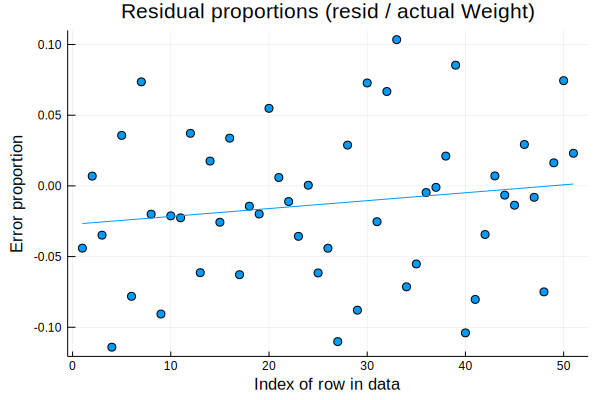

In [392]:
# HIDDEN
resid = y[test] .- yhat
resid_prop = resid ./ y[test]

scatter(collect(range(1, stop=length(resid_prop))), resid_prop, regression=true, legend=false)
title!("Residual proportions (resid / actual Weight)")
xlabel!("Index of row in data")
ylabel!("Error proportion")

Looks like our model does pretty well! The residual proportions indicate that our predictions are mostly within 15% of the correct value.